In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision.datasets import ImageFolder


import os
import sys
import time
import math
import argparse
import datetime
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from numpy import interp
from itertools import cycle
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from statistics import NormalDist
from scipy.stats import bootstrap


In [2]:
class MyModel(nn.Module):
    def __init__(self, model):
        super(MyModel, self).__init__()
        self.model = model
        self.model.fc = nn.Linear(self.model.fc.in_features, 3)

    def forward(self, input):
        return self.model(input)


In [3]:
runNum = 1

model_num = 9

batchSize = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load("./runs/train-{}/model_{}.pth".format(runNum, model_num)).to(device)

model.eval()

transform = T.Compose(
    [
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

lossFunction = nn.CrossEntropyLoss()

validateDataset = ImageFolder("./images/validate", transform)

validateDataloder = DataLoader(validateDataset, batch_size=batchSize)

i = 0

trueValue = []
predValue = []
predProb = []
imagePath = []
pred_res = []

for step, (image, label) in enumerate(validateDataloder):
    with torch.no_grad():
        image = image.to(device)
        label = label.to(device)
        out = model(image)
        loss = lossFunction(out, label)
        pred = out.argmax(1)
        if pred.item() != label.item():
            i += 1
        trueValue.append(label.item())
        predProb.append(
            torch.nn.functional.softmax(out, dim=1)
            .detach()
            .cpu()
            .squeeze()
            .numpy()
            .tolist()
        )
        predValue.append(pred.item())
        imagePath.append(validateDataset.samples[step][0])

for p in predValue:
    if p == 0:
        pred_res.append("Acute")
    elif p == 1:
        pred_res.append("Chronic")
    else:
        pred_res.append("Pathologic")

path_predValue = np.array((imagePath, pred_res))

path_predValue = path_predValue.T

df = pd.DataFrame(path_predValue)
df.to_csv("path_res.csv")

label_index = ["Acute", "Chronic", "Pathologic"]


In [4]:
def get_p_r_f1_from_conf_matrix(conf_matrix):
    labels = [0, 1, 2]
    nums = len(labels)
    tp = []
    fp = []
    fn = []
    tn = []
    pr = []
    rc = []
    F1 = []
    for i in labels:
        # TP, FP, FN, TN = 0, 0, 0, 0
        TP = conf_matrix[i, i]
        FP = conf_matrix[:i, i].sum() + conf_matrix[i + 1 :, i].sum()
        FN = conf_matrix[i, i + 1 :].sum() + conf_matrix[i, :i].sum()
        TN = conf_matrix[:, :].sum() - TP - FN - FP

        tp.append(TP)
        fp.append(FP)
        fn.append(FN)
        tn.append(TN)

        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1 = 2 * precision * recall / (precision + recall)

        pr.append(precision)
        rc.append(recall)
        F1.append(f1)

    head = ["TP", "FP", "FN", "TN", "PR", "RC", "F1"]

    df_np = np.array([tp, fp, fn, tn, pr, rc, F1])
    df = pd.DataFrame(df_np, columns=["Acute", "Chronic", "Pathologic"])

    df["index"] = head

    df.to_csv("res.csv")


In [5]:
def get_acc_from_conf_matrix(conf_matrix):
    labels = [0, 1, 2]
    return sum([conf_matrix[i, i] for i in range(len(labels))]) / np.sum(
        np.sum(conf_matrix, axis=0)
    )


In [6]:
def confidence_interval(predProb):

    rng = np.random.RandomState(42)

    bootstrap_n = 1000

    one_true = []
    one_pred = []

    one_len = len(os.listdir(os.path.join("./images/validate/Acute")))
    two_len = len(os.listdir(os.path.join("./images/validate/Chronic")))
    three_len = len(os.listdir(os.path.join("./images/validate/Pathologic")))
    all_len = one_len + two_len + three_len

    for i in range(one_len):
        one_true.append([1, 0])
        one_pred.append([predProb[i][0], 1 - predProb[i][0]])

    for i in range(one_len, all_len):
        one_true.append([0, 1])
        one_pred.append([predProb[i][0], 1 - predProb[i][0]])

    temp_true = one_true
    temp_pred = one_pred

    one_res = []
    for i in range(bootstrap_n):
        indices = rng.randint(0, len(temp_true), len(temp_pred))
        one_res.append(
            roc_auc_score(np.array(temp_true)[indices], np.array(temp_pred)[indices])
        )

    data = (one_res,)

    lh = bootstrap(
        data,
        np.mean,
        random_state=rng,
    )
    one_low, one_high, one_sd = (
        lh.confidence_interval.low,
        lh.confidence_interval.high,
        lh.standard_error,
    )

    two_true = []
    two_pred = []

    for i in range(one_len):
        two_true.append([0, 1])
        two_pred.append([predProb[i][1], 1 - predProb[i][1]])

    for i in range(one_len, one_len + two_len):
        two_true.append([1, 0])
        two_pred.append([predProb[i][1], 1 - predProb[i][1]])

    for i in range(one_len + two_len, all_len):
        two_true.append([0, 1])
        two_pred.append([predProb[i][1], 1 - predProb[i][1]])

    temp_true = two_true
    temp_pred = two_pred

    two_res = []
    for i in range(bootstrap_n):
        indices = rng.randint(0, len(temp_true), len(temp_pred))
        two_res.append(
            roc_auc_score(np.array(temp_true)[indices], np.array(temp_pred)[indices])
        )

    data = (two_res,)

    lh = bootstrap(
        data,
        np.mean,
        random_state=rng,
    )
    two_low, two_high, two_sd = (
        lh.confidence_interval.low,
        lh.confidence_interval.high,
        lh.standard_error,
    )

    three_true = []
    three_pred = []

    for i in range(one_len + two_len):
        three_true.append([0, 1])
        three_pred.append([predProb[i][2], 1 - predProb[i][2]])

    for i in range(one_len + two_len, all_len):
        three_true.append([1, 0])
        three_pred.append([predProb[i][2], 1 - predProb[i][2]])

    temp_true = three_true
    temp_pred = three_pred

    three_res = []
    for i in range(bootstrap_n):
        indices = rng.randint(0, len(temp_true), len(temp_pred))
        three_res.append(
            roc_auc_score(np.array(temp_true)[indices], np.array(temp_pred)[indices])
        )

    data = (three_res,)

    lh = bootstrap(
        data,
        np.mean,
        random_state=rng,
    )
    three_low, three_high, three_sd = (
        lh.confidence_interval.low,
        lh.confidence_interval.high,
        lh.standard_error,
    )

    return (
        one_low,
        one_high,
        one_sd,
        two_low,
        two_high,
        two_sd,
        three_low,
        three_high,
        three_sd,
    )


In [7]:
def get_roc_auc(trues, preds):
    labels = ["Acute", "Chronic", "Pathologic"]
    nb_classes = len(labels)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    lower = dict()
    higher = dict()
    for i in range(nb_classes):
        fpr[i], tpr[i], _ = roc_curve(trues[:, i], preds[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    lw = 2
    plt.figure()
    colors = cycle(["aqua", "darkorange", "cornflowerblue"])

    (
        one_low,
        one_high,
        one_sd,
        two_low,
        two_high,
        two_sd,
        three_low,
        three_high,
        three_sd,
    ) = confidence_interval(predProb)

    ci_low = [one_low, two_low, three_low]
    ci_high = [one_high, two_high, three_high]
    ci_sd = [one_sd, two_sd, three_sd]

    for i, color in zip(range(nb_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="AUC of {} {:0.3f} (95% CI {:0.3f}-{:0.3f})".format(
                labels[i], roc_auc[i], ci_low[i], ci_high[i]
            ),
        )
    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.savefig("./ROC.png")
    plt.show()


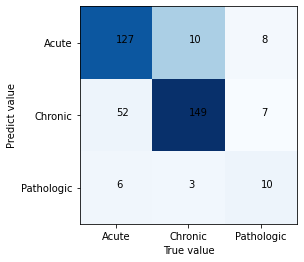

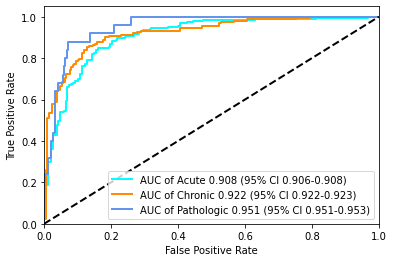

In [8]:
mt = confusion_matrix(trueValue, predValue, labels=[0, 1, 2])

plt.imshow(mt, cmap=plt.cm.Blues)
plt.xlabel("True value")
plt.ylabel("Predict value")
indices = range(len(mt))

plt.xticks(indices, ["Acute", "Chronic", "Pathologic"])
plt.yticks(indices, ["Acute", "Chronic", "Pathologic"])

for i in range(len(mt)):
    for j in range(len(mt[i])):
        plt.text(i, j, mt[i][j])

plt.savefig("./confusion_matrix.png")
plt.show()

get_p_r_f1_from_conf_matrix(mt)

test_trues = label_binarize(trueValue, classes=[i for i in range(3)])
test_preds = label_binarize(predValue, classes=[i for i in range(3)])
predProb = np.array(predProb)

get_roc_auc(test_trues, predProb)
